# FCA analysis - batch correction

In [41]:
import numpy as np
import pandas as pd
import scanpy as sc
import os
import sys


import os
os.system("export LD_LIBRARY_PATH=/home/jovyan//my-conda-envs/SCanalysis/lib/R/lib/:${LD_LIBRARY_PATH}")
# os.environ['LD_LIBRARY_PATH'] = '/home/jovyan/my-conda-envs/SCanalysis/lib/R/lib/libR.so'
# os.environ['R_LIBS_USER'] = '/opt/conda/lib/R/library/methods/libs/methods.so'

def MovePlots(plotpattern, subplotdir):
    os.system('mkdir -p '+str(sc.settings.figdir)+'/'+subplotdir)
    os.system('mv '+str(sc.settings.figdir)+'/*'+plotpattern+'** '+str(sc.settings.figdir)+'/'+subplotdir)

sc.settings.verbosity = 3  # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.settings.figdir = './figures/harmony_0/'
sc.logging.print_versions()
sc.settings.set_figure_params(dpi=80)  # low dpi (dots per inch) yields small inline figures

sys.executable

-----
anndata     0.7.5
scanpy      1.7.0rc1
sinfo       0.3.1
-----
PIL                 8.1.2
anndata             0.7.5
anyio               NA
attr                20.3.0
babel               2.9.0
backcall            0.2.0
brotli              NA
cairo               1.20.0
certifi             2020.12.05
cffi                1.14.5
chardet             4.0.0
cloudpickle         1.6.0
colorama            0.4.4
cycler              0.10.0
cython_runtime      NA
cytoolz             0.11.0
dask                2021.03.0
dateutil            2.8.1
decorator           4.4.2
get_version         2.1
google              NA
h5py                3.1.0
harmonypy           NA
idna                2.10
igraph              0.8.3
ipykernel           5.5.0
ipython_genutils    0.2.0
jedi                0.18.0
jinja2              2.11.3
joblib              1.0.1
json5               NA
jsonschema          3.2.0
jupyter_server      1.4.1
jupyterlab_server   2.3.0
kiwisolver          1.3.1
legacy_api_wrap     0.0.0


'/opt/conda/bin/python'

## Load data

In [42]:
adata = sc.read('FCA-M1preprocessing.h5ad')
adata.X.shape

(319081, 28037)

## HARMONY correction

In [43]:
# Extract PCA matrix and batch array
n_pcs = 22
pca = adata.obsm['X_pca'][:, 0:(n_pcs)]
# batch = adata.obs['individual']

In [44]:
import harmonypy as hm
ho = hm.run_harmony(pca, adata.obs, 'individual', theta = 0)


2021-04-10 13:59:34,008 - harmonypy - INFO - Iteration 1 of 10
Iteration 1 of 10
2021-04-10 14:04:32,641 - harmonypy - INFO - Iteration 2 of 10
Iteration 2 of 10
2021-04-10 14:08:30,776 - harmonypy - INFO - Iteration 3 of 10
Iteration 3 of 10
2021-04-10 14:12:14,775 - harmonypy - INFO - Iteration 4 of 10
Iteration 4 of 10
2021-04-10 14:15:57,387 - harmonypy - INFO - Iteration 5 of 10
Iteration 5 of 10
2021-04-10 14:19:33,646 - harmonypy - INFO - Converged after 5 iterations
Converged after 5 iterations


In [45]:
# Add harmony values to the anndata object
res = pd.DataFrame(ho.Z_corr)
res.columns = ['X{}'.format(i + 1) for i in range(res.shape[1])]
adata.obsm['X_pca'] = res.to_numpy().T

In [46]:
# # Batch-correct the PCA using HARMONY method
# %load_ext rpy2.ipython 

In [47]:
# %%R 
# R.Version()

In [48]:
# %%R -i pca -i batch -o hem

# library(harmony)
# library(magrittr)
# library(Rcpp)
# set.seed(10)
# hem <- HarmonyMatrix(pca, batch, theta=1, do_pca=FALSE, verbose = FALSE)
# hem = data.frame(hem)

In [49]:
# # Add harmony values to the anndata object
# adata.obsm['X_pca'] = hem.values

In [50]:
# Visualize
sc.pp.neighbors(adata, n_pcs = n_pcs)
sc.tl.umap(adata)

computing neighbors
    using 'X_pca' with n_pcs = 22
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:34)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:03:30)


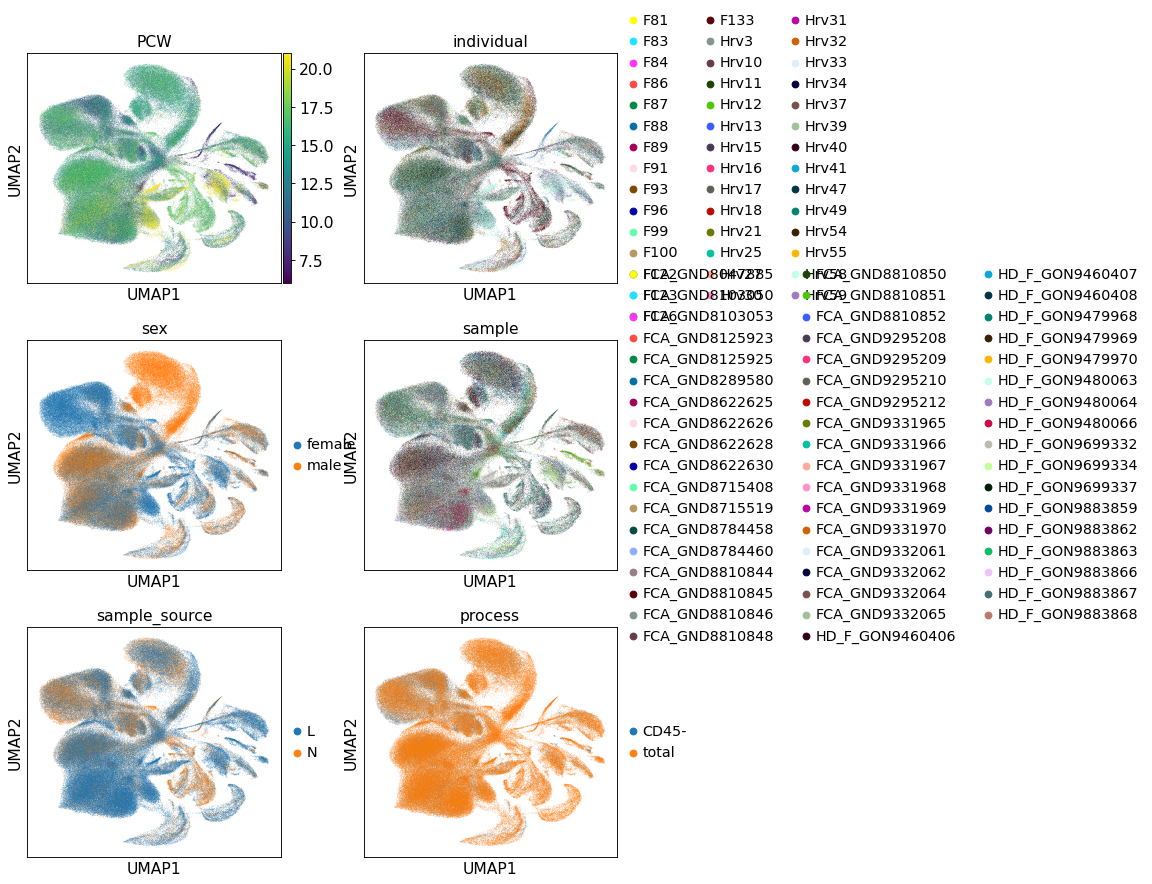

In [51]:
sc.pl.umap(adata, color=['PCW', 'individual', 'sex', 'sample', 'sample_source', 'process'], save='_harmony.pdf', ncols=2)

The lists are not identical


... storing 'clusters' as categorical


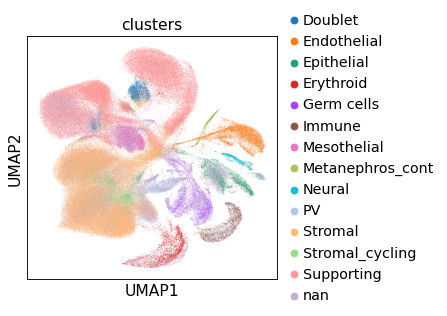

In [52]:
# Add old cluster name
clu_annot = pd.read_csv('../scRNAseq_analysis_FCA_2sex/figures_manual_annotation/clustering_metadata.csv', header=0, index_col=0)
import collections 

if collections.Counter(adata.obs.index) == collections.Counter(clu_annot.index): 
    print ("The lists are identical") 
else : 
    print ("The lists are not identical") 
    
vars2import = ['clusters']
for var in vars2import:
    adata.obs[var] = clu_annot[var]
sc.pl.umap(adata, color=['clusters'], ncols = 4, color_map='OrRd', use_raw=False, save='_harmony_oldclustering.pdf')

... storing 'sub_clusters' as categorical


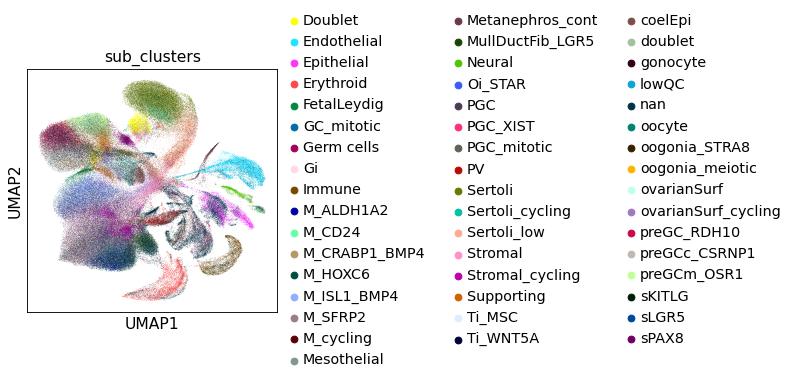

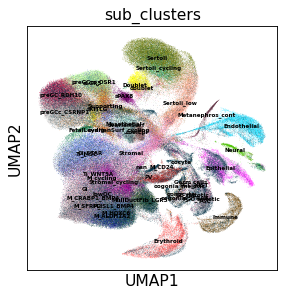

In [53]:
# Add old cluster subname
meta_som = pd.read_csv('/nfs/team292/lg18/with_valentina/gonadsV1_freezed/supporting_annotated.csv')
meta_som = meta_som.set_index('Unnamed: 0')
meta_som.head()

meta_germ = pd.read_csv('/nfs/team292/lg18/with_valentina/gonadsV1_freezed/germcells_annotated.csv')
meta_germ = meta_germ.set_index('Unnamed: 0')
meta_germ.head()

meta_mes = pd.read_csv('/nfs/team292/lg18/with_valentina/gonadsV1_freezed/mesenchymalPV_annotated.csv')
meta_mes = meta_mes.set_index('Unnamed: 0')
meta_mes.head()

som_cell_annot = meta_som['annotated_clusters'].to_dict()
germ_cell_annot = meta_germ['annotated_clusters'].to_dict()
mes_cell_annot = meta_mes['annotated_clusters'].to_dict()
cell_annot = {**som_cell_annot, **germ_cell_annot, **mes_cell_annot}
adata.obs['sub_clusters'] = adata.obs_names.map(cell_annot)

# Replace NaN with big clusters 
adata.obs['sub_clusters'] = adata.obs['sub_clusters'].fillna(adata.obs['clusters'])
sc.pl.umap(adata, color=['sub_clusters'], ncols = 4, color_map='OrRd', use_raw=False)
sc.pl.umap(adata, color=['sub_clusters'], ncols = 4, color_map='OrRd', use_raw=False, legend_loc='on data', legend_fontsize=5, save='_harmony_oldsubclustering.pdf')

# Save

In [54]:
adata.write('FCA-M2harmony_theta0.h5ad')
adata.X.shape

(319081, 28037)

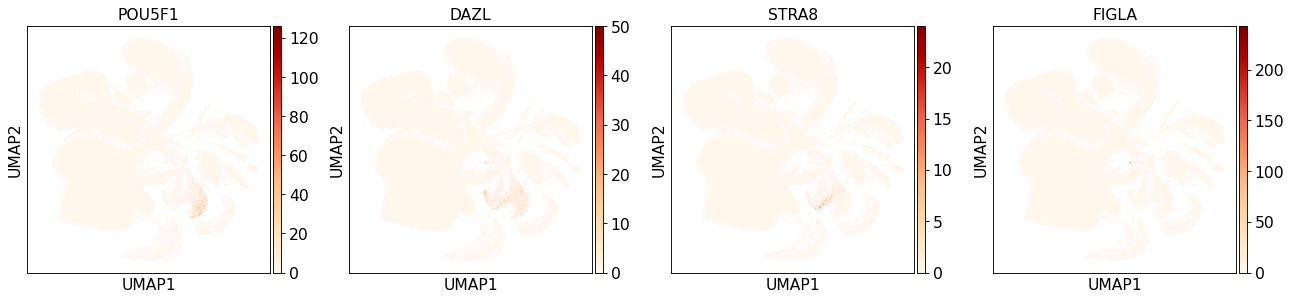

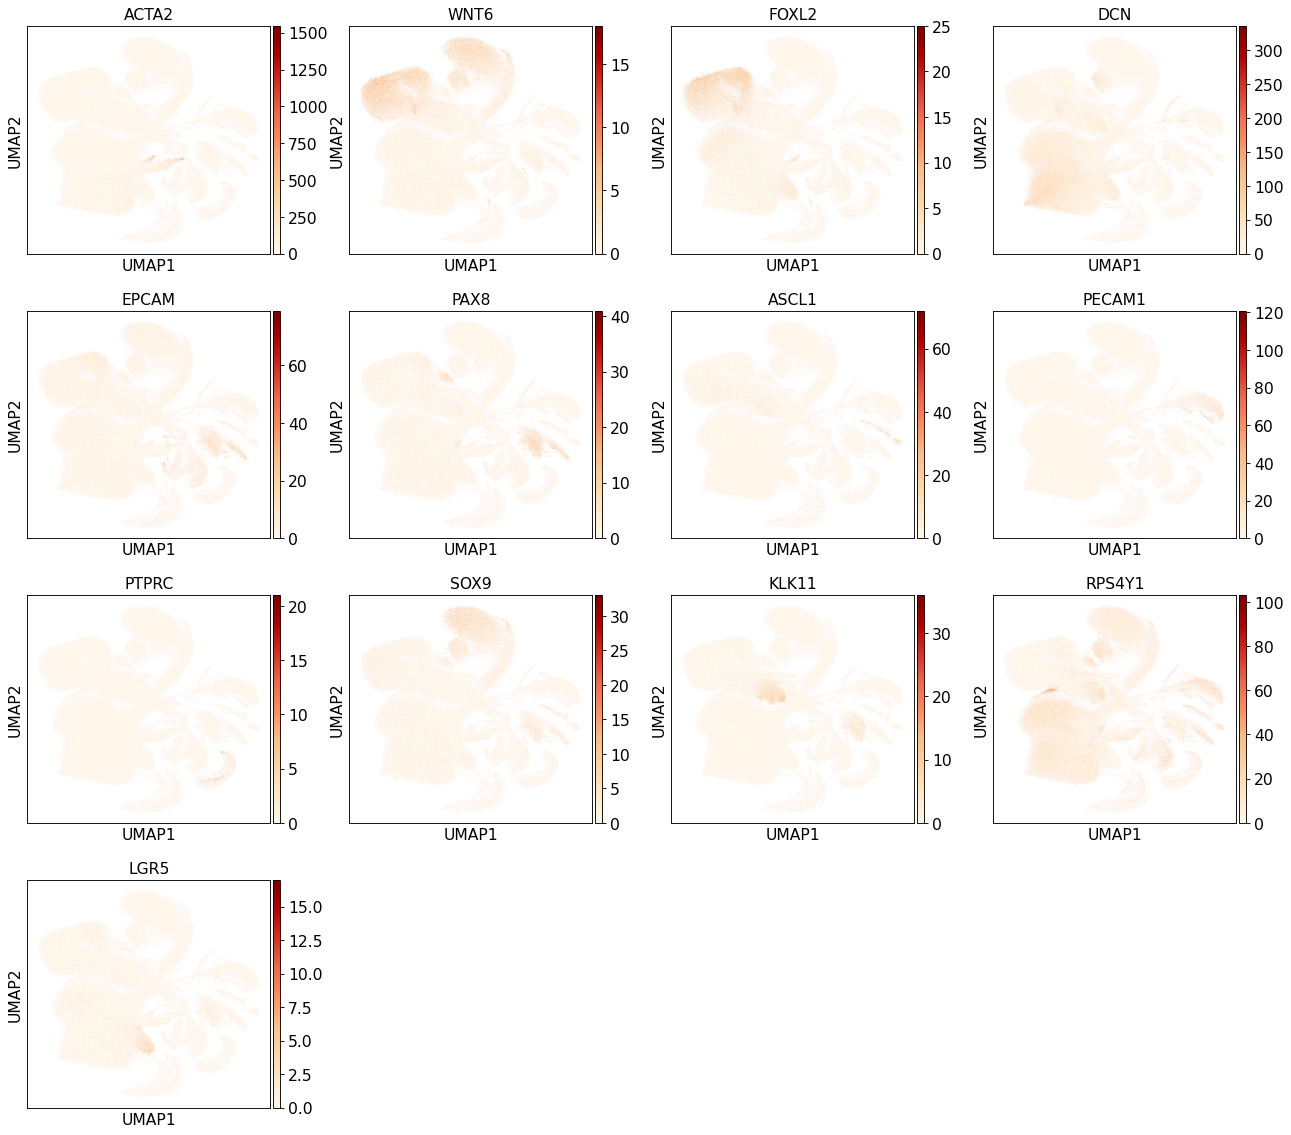

In [55]:
sc.pl.umap(adata, color=['POU5F1', 'DAZL', 'STRA8', 'FIGLA'], save='_germcells.pdf', ncols = 4, color_map='OrRd', use_raw=True)
sc.pl.umap(adata, color=['ACTA2', "WNT6", "FOXL2", "DCN", "EPCAM", "PAX8", 'ASCL1', 'PECAM1', 'PTPRC', 'SOX9', 'KLK11', 'RPS4Y1','LGR5'], save='-markers_global.pdf',color_map='OrRd', use_raw=True)

running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 15 clusters and added
    'louvain', the cluster labels (adata.obs, categorical) (0:01:09)


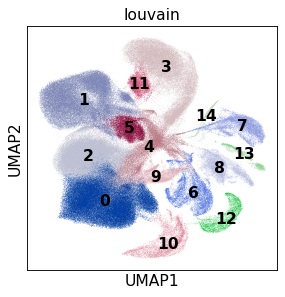

In [61]:
# sc.tl.louvain(adata, resolution=0.4)
sc.tl.louvain(adata, resolution=0.2)
sc.pl.umap(adata, color=['louvain'],legend_loc='on data')

In [62]:
def Barplot(which_var, adata, var='clusters', height=3, color = False):
    plotdata = pd.crosstab(adata.obs[var], adata.obs[which_var], normalize='index') * 100
    if 'category' in plotdata.index.dtype.name:
        plotdata.index.reorder_categories(adata.obs[var].cat.categories[::-1])

    if not color:
        ax1 = plotdata.plot.barh(stacked = True, edgecolor = 'none', zorder = 3, figsize = (6,height), fontsize = 14, grid = False)
    else:
        ax1 = plotdata.plot.barh(stacked = True, edgecolor = 'none', zorder = 3, figsize = (6,height), fontsize = 14, grid = False, color = color)
    ax1.set_title(which_var+' %')
    ax1.set_ylabel(var)
    horiz_offset = 1
    vert_offset = 1.
    ax1 = ax1.legend(bbox_to_anchor = (horiz_offset, vert_offset))
    ax1.figure.savefig(str(sc.settings.figdir)+'/barplot_'+var+'_proportions_'+which_var+'.pdf', bbox_inches='tight',
                       dpi=300, orientation='landscape', format= 'pdf', optimize=True)

<ipython-input-62-915a50b4f938>:15: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "optimize" which is no longer supported as of 3.3 and will become an error two minor releases later
  ax1.figure.savefig(str(sc.settings.figdir)+'/barplot_'+var+'_proportions_'+which_var+'.pdf', bbox_inches='tight',


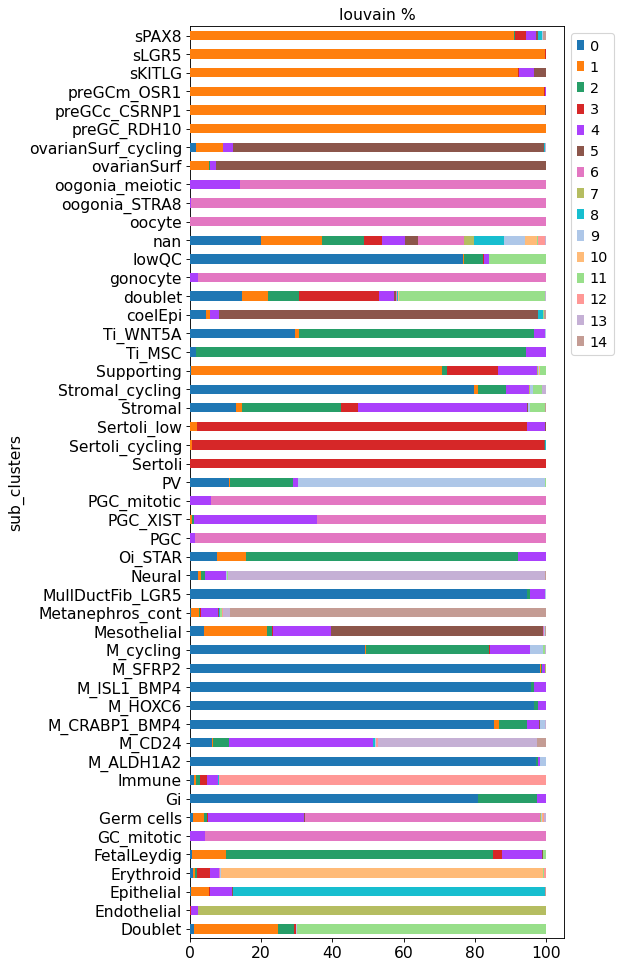

In [64]:
Barplot('louvain', adata, var='sub_clusters', height=15)

#### 